In [1]:
import pandas as pd
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100
import scipy.stats as stats

from sklearn import preprocessing


import warnings 
warnings.filterwarnings(action= 'ignore')

#### City of San Diego - Data SD
* Dataset name: Monitoring of Indicator Bacteria in Drinking Water
* URL: https://data.sandiego.gov/datasets/monitoring-of-indicator-bacteria-in-drinking-water/

In [2]:
# All Drinking Water Tests(Bacteria)
df = pd.read_csv('https://seshat.datasd.org/water_testing/indicator_bacteria_tests_datasd_v1.csv')
df.shape

(85095, 9)

In [3]:
# Information about observations in data set
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85095 entries, 0 to 85094
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   FR_NUM        85095 non-null  int64  
 1   date_sampled  85095 non-null  object 
 2   source        85095 non-null  object 
 3   sample_id     85095 non-null  object 
 4   t_coliform    85026 non-null  object 
 5   cl2_total     85095 non-null  float64
 6   e_coli        85037 non-null  object 
 7   temperature   85095 non-null  float64
 8   ph            85095 non-null  float64
dtypes: float64(3), int64(1), object(5)
memory usage: 5.8+ MB


In [4]:
# total observations with missing information
nulls_df = df.isnull().sum().to_frame().reset_index()
nulls_df.columns=['Field', 'TotalNulls']

# total rows in data frame by field
field_totals_df = df.count().to_frame().reset_index()
field_totals_df.columns=['Field', 'RowsWithData']

# merge data together
nulls_df = nulls_df.query("TotalNulls != 0").merge(field_totals_df, left_on='Field', right_on='Field', how='inner')

# percentage of Null rows
nulls_df['PctNull'] = round(nulls_df.TotalNulls / nulls_df.RowsWithData,3)

# result
nulls_df.style.hide_index()

Field,TotalNulls,RowsWithData,PctNull
t_coliform,69,85026,0.001000
e_coli,58,85037,0.001000


In [5]:
# drop observations missing data and resulting shape
print('Original shape:                  ', df.shape)

df.dropna(inplace=True)
print('Shape after dropping null values:', df.shape)

Original shape:                   (85095, 9)
Shape after dropping null values: (85026, 9)


In [6]:
# final check for missing information
for n in (set(df.isnull().sum())):
    if n == 0:
        print('There is no more missing information')
    else:
        print('There is still missing information')

There is no more missing information


In [7]:
print('''"pH: potential of hydrogen. pH is a measure of how acidic or basic water is. 
The range goes from 0 - 14, with 7 being neutral. pHs of less than 7 indicate acidity, 
whereas pHs greater than 7 are basic (The City of San Diego, 2022, p.8).
''')

print('''References: 
The City of San Diego. (2022). The City of San Diego Annual Drinking Water Quality Report 2022. https://www.sandiego.gov/sites/default/files/hyperlink_wqr_2022.pdf''')


# Data Dictionary provided by source
dict_df = pd.read_csv('https://seshat.datasd.org/water_testing/indicator_bacteria_tests_dictionary_datasd.csv').fillna('')
dict_df

"pH: potential of hydrogen. pH is a measure of how acidic or basic water is. 
The range goes from 0 - 14, with 7 being neutral. pHs of less than 7 indicate acidity, 
whereas pHs greater than 7 are basic (The City of San Diego, 2022, p.8).

References: 
The City of San Diego. (2022). The City of San Diego Annual Drinking Water Quality Report 2022. https://www.sandiego.gov/sites/default/files/hyperlink_wqr_2022.pdf


,Field,Description,Possible values
0,sample_date,Date sample was taken,
1,site_ID,Unique identifier for the sample site,
2,temp_celsius,Temperature in Celsius,
3,chlorine,Chlorine in mg/l or ppm,
4,pH,pH of water sample,0-14
5,coliform,Presence of Coliform indicator bacteria,"A-Absent, P-Present"
6,E.coli,Presence of E.coli indicator bacteria,"A-Absent, P-Present"


In [8]:
# Value counts for t_coliform, to determine how to treat missing values
# the value '<' is being used, as it is included in data set, and being applied to missing values as well.
# According to data dictionary, only values A and P are valid
print(df.t_coliform.fillna("blank").value_counts())

# Values A and P are valid according to dictionary, "missing" and "<" values will be removed
# Update 't_coliform' with "<" so that it is easier to delete in next step
df['t_coliform'] = df.t_coliform.fillna("<")

# Since missing values and "<" are not in data dictionary; delete rows
df = df.query("t_coliform != '<'")
print("\n","df shape after dropping t_coliform invalid rows:")
print(df.shape)

# Missing values re-check
print("\n")
print(df.t_coliform.fillna("<").value_counts())

A    84792
P      127
<      107
Name: t_coliform, dtype: int64

 df shape after dropping t_coliform invalid rows:
(84919, 9)


A    84792
P      127
Name: t_coliform, dtype: int64


In [9]:
# Data conversion
df['date_sampled'] =  pd.to_datetime(df.date_sampled)

In [10]:
# if able to gain access to weather data, it would need to be between these date ranges
print('date_sampled min date:', df.date_sampled.min().strftime("%Y-%d-%m"))
print('date_sampled max date:', df.date_sampled.max().strftime("%Y-%d-%m"))

date_sampled min date: 2014-02-06
date_sampled max date: 2023-01-09


In [11]:
print('''A value_counts for sample_id shows that there 
are multiple rows per sample_id:''')
df.sample_id.value_counts().head()

A value_counts for sample_id shows that there 
are multiple rows per sample_id:


W1569942    16
W1451682    16
W1472462    16
W1429815    16
W1278707    16
Name: sample_id, dtype: int64

In [12]:
# load sample_id value counts into dictionary
sample_id_dict = dict(df.sample_id.value_counts())

# identify sample_id values with multiple rows, and place their value into a list
sample_id_duplicates_list = []

for v, k in sample_id_dict.items():
    """ Only return sample_id values that are represented in multiple rows"""
    if k > 1:
        sample_id_duplicates_list.append(v)

In [13]:
for si in (pd.DataFrame(sample_id_duplicates_list)[0].sample(1)):
    sample_id_var = si

print('''Querying the sample_id values identified to have multiple rows, shows that FR_NUM, date_sampled, source, 
sample_id, t_coliform, and e_coli are the same values for these multiple rows; however, 
cl2_total, temperature, and ph have similar values but not the same.''')

df.query("sample_id == @sample_id_var")

Querying the sample_id values identified to have multiple rows, shows that FR_NUM, date_sampled, source, 
sample_id, t_coliform, and e_coli are the same values for these multiple rows; however, 
cl2_total, temperature, and ph have similar values but not the same.


,FR_NUM,date_sampled,source,sample_id,t_coliform,cl2_total,e_coli,temperature,ph
51217,353562,2020-09-24,231 SYS,W1391702,A,3.28,A,25.6,8.23
51218,353562,2020-09-24,231 SYS,W1391702,A,3.28,A,25.6,8.22
51219,353562,2020-09-24,231 SYS,W1391702,A,3.28,A,25.9,8.23
51220,353562,2020-09-24,231 SYS,W1391702,A,3.28,A,25.9,8.22
51221,353562,2020-09-24,231 SYS,W1391702,A,3.28,A,25.6,8.23
51222,353562,2020-09-24,231 SYS,W1391702,A,3.28,A,25.6,8.22
51223,353562,2020-09-24,231 SYS,W1391702,A,3.28,A,25.9,8.23
51224,353562,2020-09-24,231 SYS,W1391702,A,3.28,A,25.9,8.22
51225,353562,2020-09-24,231 SYS,W1391702,A,3.24,A,25.6,8.23
51226,353562,2020-09-24,231 SYS,W1391702,A,3.24,A,25.6,8.22


In [14]:
# Create dataframe from value_counts to identify columns that can be updated, as they appear to be duplicates
df2 = df[['FR_NUM', 'date_sampled', 'source', 'sample_id']].value_counts().to_frame(name='Counts')

df2 = df2.reset_index() # places "Counts" into the header row with all other columns

# Only keep columns with Counts greater than 1
df2 = df2.query("Counts > 1")

# Merge values from original dataframe, to get averages for these rows requiring averages for duplicate rows
df2 = df2.merge(df, left_on=('FR_NUM', 'date_sampled', 'source', 'sample_id'), right_on=('FR_NUM', 'date_sampled', 'source', 'sample_id'), how="inner")

In [15]:
# Itirate through sample_id values with multiply rows to get averages from their means for:
# cl2_total, temperature, and ph

df2_means = []

for si in (set(sample_id_duplicates_list)):

    df2_means.append({'sample_id': si,
                      'cl2_total_mean': df.query("sample_id == @si").cl2_total.mean(),
                      'temperature_mean': df.query("sample_id == @si").temperature.mean(),
                      'ph_mean': df.query("sample_id == @si").ph.mean()})

In [16]:
# Merge average values into original dataframe
# The use of "left" join in the merge statement above, leaves non-duplicate values empty
# ensuring no loss of data
df = df.merge(pd.DataFrame(df2_means), left_on=('sample_id'), right_on=('sample_id'), how="left")

In [17]:
# Make updates to duplicate sample_id respective features with their means
# in the fillna statements below:
df['cl2_total'] = np.where(df.cl2_total_mean.fillna("") != "", df.cl2_total_mean, df.cl2_total)
df['temperature'] = np.where(df.temperature_mean.fillna("") != "", df.temperature_mean, df.temperature)
df['ph'] = np.where(df.ph_mean.fillna("") != "", df.ph_mean, df.ph)

In [18]:
# With all variations gone, we can now drop duplicates.
df.drop_duplicates(inplace=True)
print('shape after dropping duplicates:')
print(df.shape)

shape after dropping duplicates:
(61979, 12)


In [19]:
print('''Remaining unique rows for each sample_id:''')
for u in (set(pd.DataFrame(set(df.sample_id)).value_counts().values)):
    print(u)

Remaining unique rows for each sample_id:
1


In [20]:
# Review of sample_id referenced, to confirm single row returned with mean values
df.query("sample_id == @sample_id_var")

,FR_NUM,date_sampled,source,sample_id,t_coliform,cl2_total,e_coli,temperature,ph,cl2_total_mean,temperature_mean,ph_mean
51116,353562,2020-09-24,231 SYS,W1391702,A,3.26,A,25.75,8.225,3.26,25.75,8.225


In [21]:
# Drop unnecessary columns for remainder of the process - used in previous steps
df = df.drop(['cl2_total_mean', 'temperature_mean', 'ph_mean'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61979 entries, 0 to 84918
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   FR_NUM        61979 non-null  int64         
 1   date_sampled  61979 non-null  datetime64[ns]
 2   source        61979 non-null  object        
 3   sample_id     61979 non-null  object        
 4   t_coliform    61979 non-null  object        
 5   cl2_total     61979 non-null  float64       
 6   e_coli        61979 non-null  object        
 7   temperature   61979 non-null  float64       
 8   ph            61979 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 4.7+ MB


In [22]:
# Based on the results from the above, it appears the data is ordered by date_sampled

# To ensure that all rows are following this pattern, the next step will 
# sort rows by date_sampled, source, and sample_id to get a chronological, to prepare for Time Series analysis

df.sort_values(['date_sampled', 'FR_NUM'], ascending=[True, True], inplace=True)

In [23]:
# reset index, drop original index
df.reset_index(drop=True, inplace=True)

In [24]:
# ph ranges, as defined in data dictionary section
df['ph_type'] = np.where(round(df.ph) == 7, 'ph_Neutral',
                np.where(round(df.ph) < 7, 'ph_Acidity',
                np.where(round(df.ph) > 7, 'ph_Basic', 'ph_Missing')))

# validate ph ranges to values
set(round(df.ph).astype(str) + ' - ' + df.ph_type)

{'12.0 - ph_Basic',
 '2.0 - ph_Acidity',
 '20.0 - ph_Basic',
 '4.0 - ph_Acidity',
 '6.0 - ph_Acidity',
 '7.0 - ph_Neutral',
 '8.0 - ph_Basic',
 '9.0 - ph_Basic'}

In [25]:
# ph_type dummies
df = pd.concat([df,pd.get_dummies(df.ph_type)], axis=1)

# t_coliform dummies
df = pd.concat([df,pd.get_dummies(df.t_coliform)], axis=1)
df.rename(columns={'A':'t_coliform_A', 'P':'t_coliform_P'}, inplace=True)

print(df.shape)
df.sample(3)

(61979, 15)


,FR_NUM,date_sampled,source,sample_id,t_coliform,cl2_total,e_coli,temperature,ph,ph_type,ph_Acidity,ph_Basic,ph_Neutral,t_coliform_A,t_coliform_P
29436,320219,2018-10-25,151A SYS,W1269063,A,2.89,A,21.0,7.82,ph_Basic,0,1,0,1,0
16384,285689,2016-11-09,216 SYS,W1137725,A,1.41,A,23.8,8.10,ph_Basic,0,1,0,1,0
15278,282729,2016-09-12,210 SYS,W1127434,A,2.50,A,26.3,8.14,ph_Basic,0,1,0,1,0


In [26]:
# Given that ph_Basic contains the majority of the information for ph types, the other two and ph_type will be dropped
df.ph_type.value_counts()

ph_Basic      61903
ph_Neutral       70
ph_Acidity        6
Name: ph_type, dtype: int64

In [27]:
# drop ph related columns as explained in chunk above
df.drop(columns=['ph_Neutral', 'ph_Acidity', 'ph_type'], inplace=True)

In [28]:
# Given that t_coliform values of 'A' are dominant in the data set, t_coliform_P will be dropped, along with t_coliform
df.t_coliform.value_counts()

A    61872
P      107
Name: t_coliform, dtype: int64

In [29]:
# drop t_coliform related columns as explained in chunk above
df.drop(columns=['t_coliform_P', 't_coliform'], inplace=True)

In [31]:
# given that all values in the e_coli feature are one single value, e_coli will be dropped from the data set,
# as its lack of variation, does not offer insight to the data set
df.e_coli.value_counts()

A    61979
Name: e_coli, dtype: int64

In [32]:
# drop e_coli per explanation in chunk above
df.drop(columns=['e_coli'], inplace=True)

In [33]:
df.sample(3)

,FR_NUM,date_sampled,source,sample_id,cl2_total,temperature,ph,ph_Basic,t_coliform_A
56412,389589,2022-11-02,307 SYS,W1528028,2.41,24.10,8.135,1,1
35568,336476,2019-09-30,234A SYS,W1329108,0.64,23.75,7.650,1,1
5710,258673,2015-04-08,44 SYS,W1039711,2.30,20.80,8.140,1,1


#### Outliers


In [34]:
# Outlier Analysis

# this function idea is from the Udemy "Feature Engineering for Machine Learning" course
def diagnostic_plots(df, variable, conversion):
    # function takes a dataframe and
    # the variable of interest

    # variable conversion
    if conversion == 'l':
        conv_var = np.log(df[variable])
        print('conversion: log')
    elif conversion == 's':
        conv_var = np.sqrt(df[variable])
        print('conversion: sqrt')
    elif conversion == 'c':
        conv_var = np.cbrt(df[variable])
        print('conversion: cbrt')
    elif conversion == 'a':
        conv_var = np.abs(df[variable])
        print('conversion: abs')
    else:
        conv_var = df[variable]
        print('conversion: none')    

    # define plot figure size
    plt.figure(figsize=(14,3))

    # histogram
    plt.subplot(1,3,1)
    sns.distplot(conv_var, bins=30)
    plt.title('Histogram')

    # Q-Q plot
    plt.subplot(1,3,2)
    stats.probplot(conv_var, dist="norm", plot=plt)
    plt.ylabel('RM quantiles')

    # boxplot
    plt.subplot(1,3,3)
    sns.boxplot(y=conv_var)
    plt.title('Boxplot')

    plt.show()

In [35]:
# Function to find outliers by their respective high and low boundary, Gaussian distribution
# Got this idea from same Udemy video mentioned above
def find_normal_boundaries(df, variable, distance):

    upper_boundary = df[variable].mean() + distance * df[variable].std()
    lower_boundary = df[variable].mean() - distance * df[variable].std()

    return lower_boundary, upper_boundary

In [36]:
# dictionary with conversion options
conversion_options = {'l': 'log', 's': 'sqrt', 'c': 'cbrt', 'a': 'abs'}

# print conversion options, key and values
for kv in (conversion_options.items()):
    print(kv)

('l', 'log')
('s', 'sqrt')
('c', 'cbrt')
('a', 'abs')


#### cl2_total

conversion: cbrt


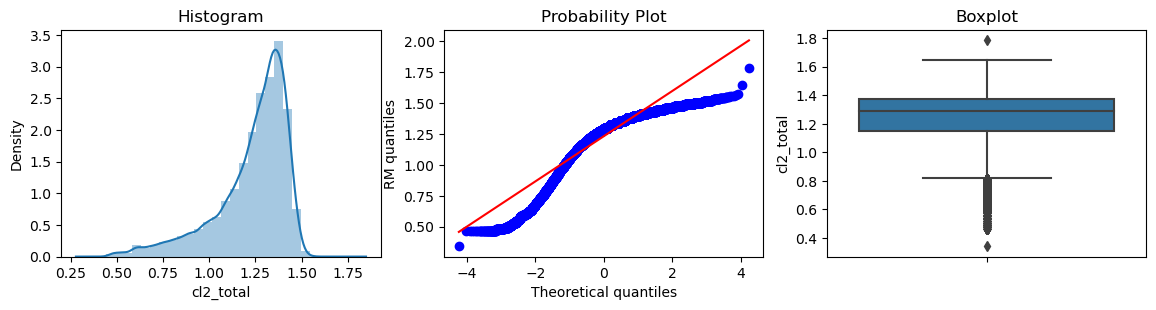

conversion: abs


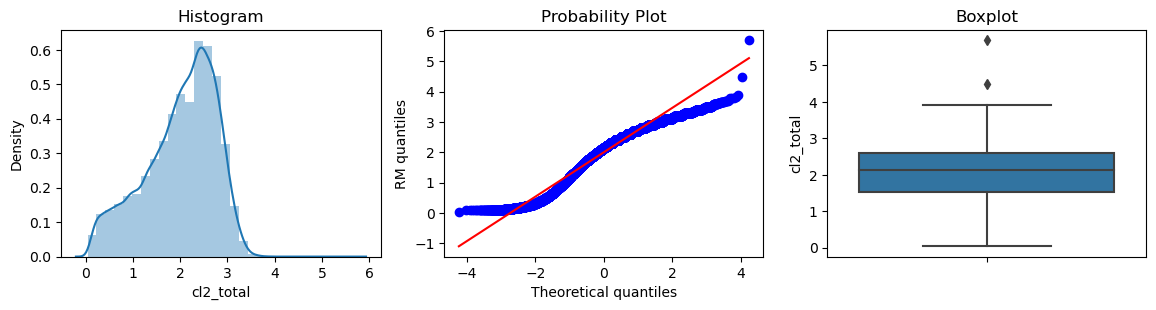

conversion: log


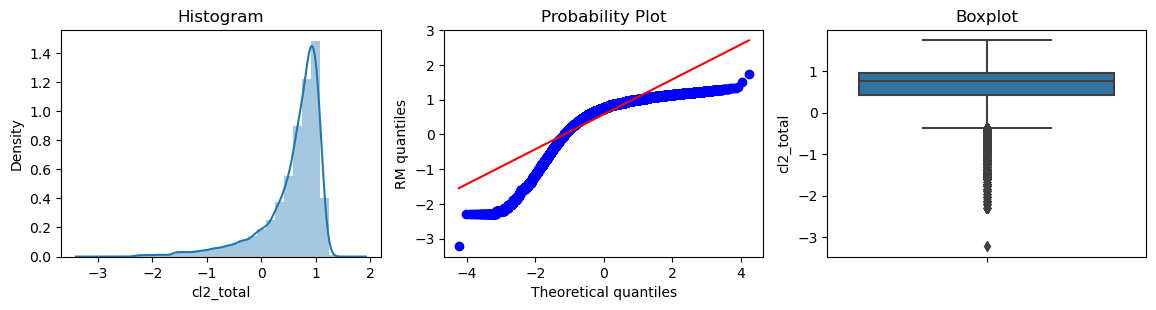

conversion: sqrt


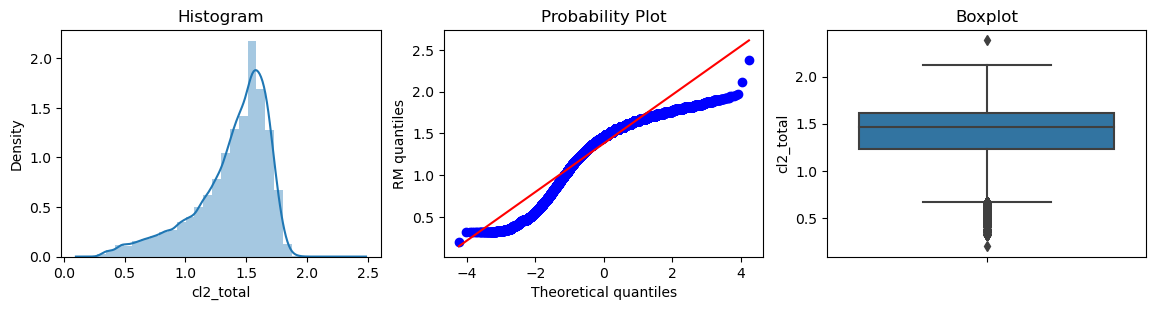

In [37]:
for conversion_type in (set(conversion_options.keys())):
    diagnostic_plots(df, 'cl2_total', conversion_type)

In [62]:
print('''The absolute value of cl2_total will be used as it has the best spread.
To address the outlier on the upper range, it will go through transformation in the next step''')

The absolute value of cl2_total will be used as it has the best spread.
To address the outlier on the upper range, it will go through transformation in the next step


In [38]:
# find lower and upper boundaries of 'cl2_total'
temperature_lower_limit, temperature_upper_limit = find_normal_boundaries(df, 'cl2_total', 3)

# Apply boundaries to outliers
df['cl2_total'] = np.where(df['cl2_total'] > temperature_upper_limit, temperature_upper_limit,
                     np.where(df['cl2_total'] < temperature_lower_limit, temperature_lower_limit,
                      df['cl2_total']))

conversion: cbrt


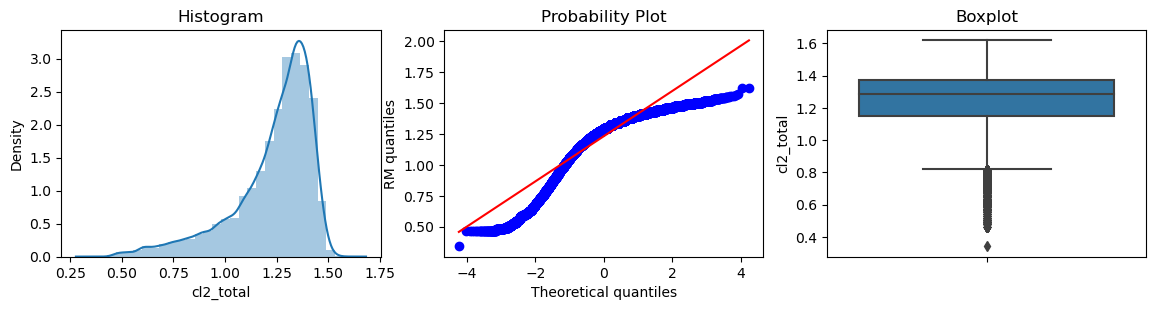

conversion: abs


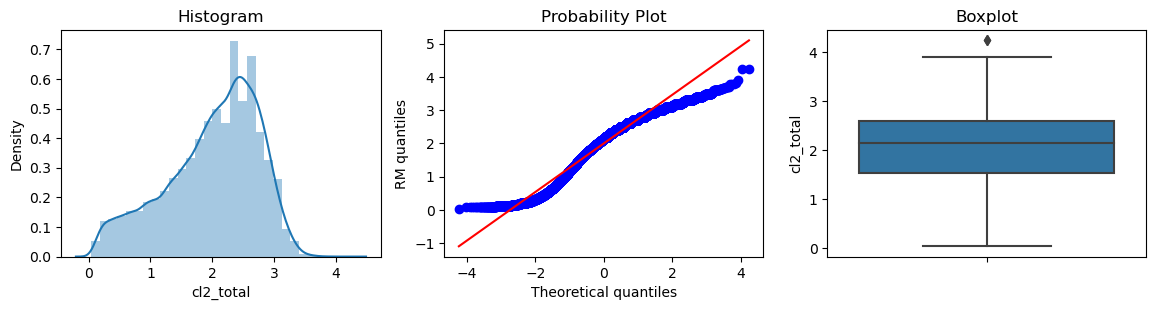

conversion: log


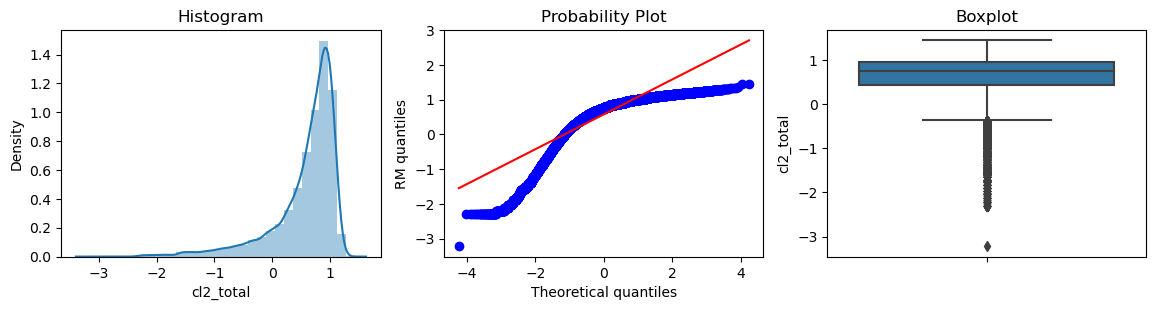

conversion: sqrt


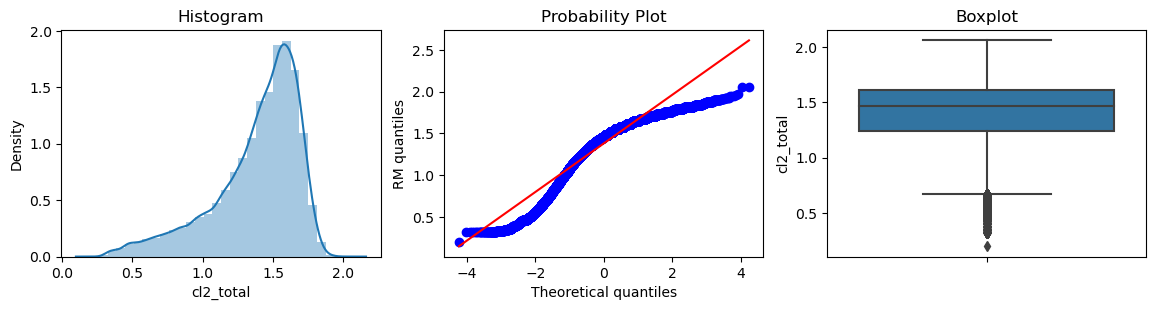

In [39]:
for conversion_type in (set(conversion_options.keys())):
    diagnostic_plots(df, 'cl2_total', conversion_type)

In [40]:
print('''After transformation, the cl2_total absolute value remains the best representation.
The outliers in the upper range were compressed, which in turn makes better use of its entire range.''')

After transformation, the cl2_total absolute value remains the best representation.
The outliers in the upper range were compressed, which in turn makes better use of its entire range.


#### temperature

conversion: cbrt


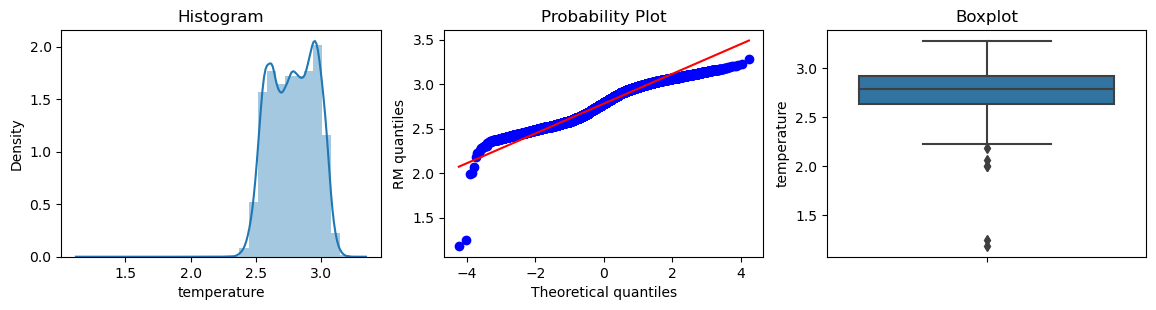

conversion: abs


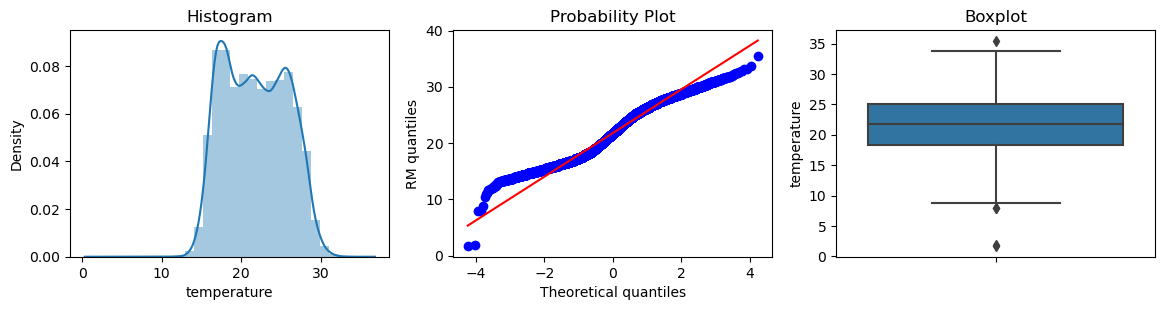

conversion: log


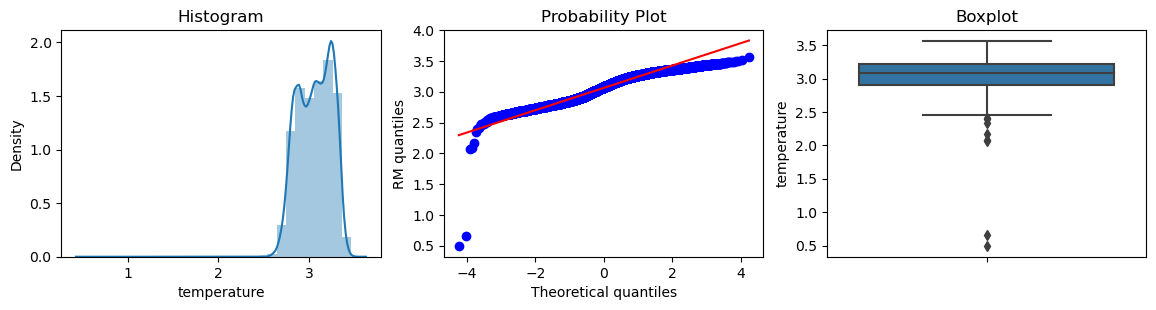

conversion: sqrt


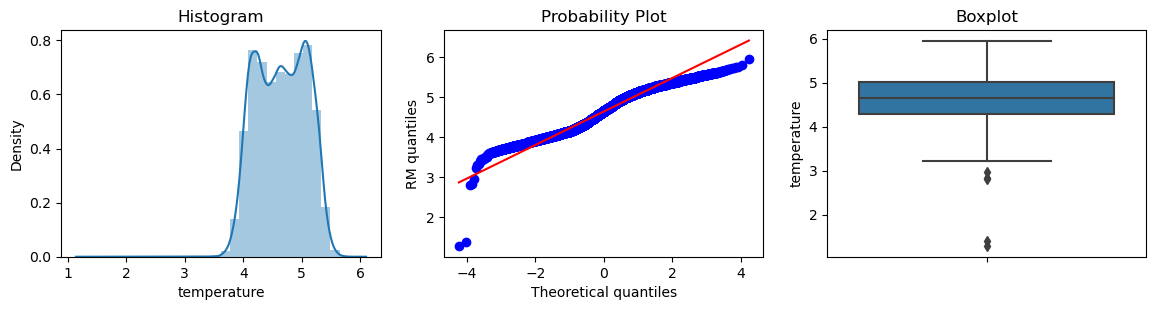

In [41]:
for conversion_type in (set(conversion_options.keys())):
    diagnostic_plots(df, 'temperature', conversion_type)

In [42]:
print(''' temperature will keep its absolute value and not go through transformation''')

 temperature will keep its absolute value and not go through transformation


#### ph

conversion: cbrt


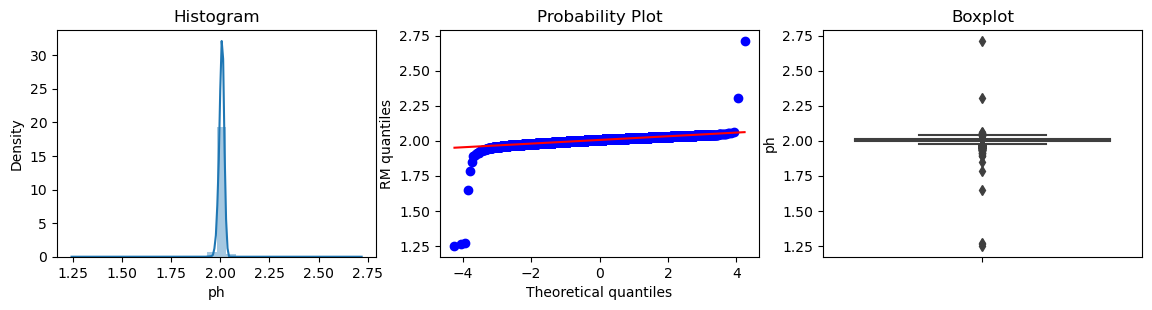

conversion: abs


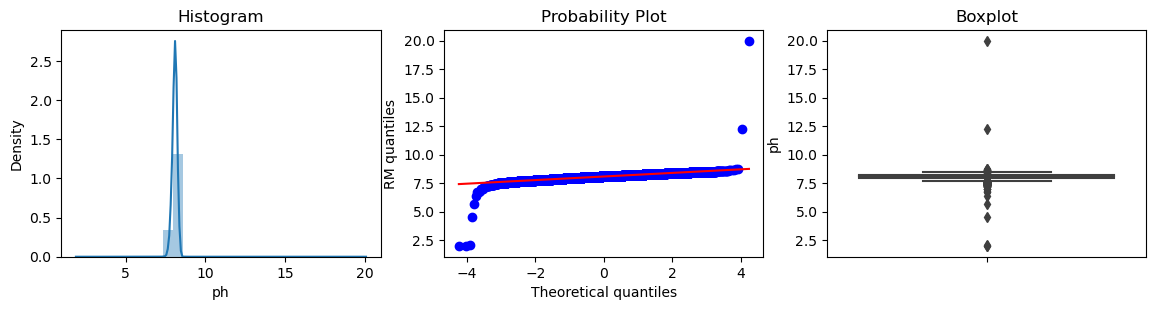

conversion: log


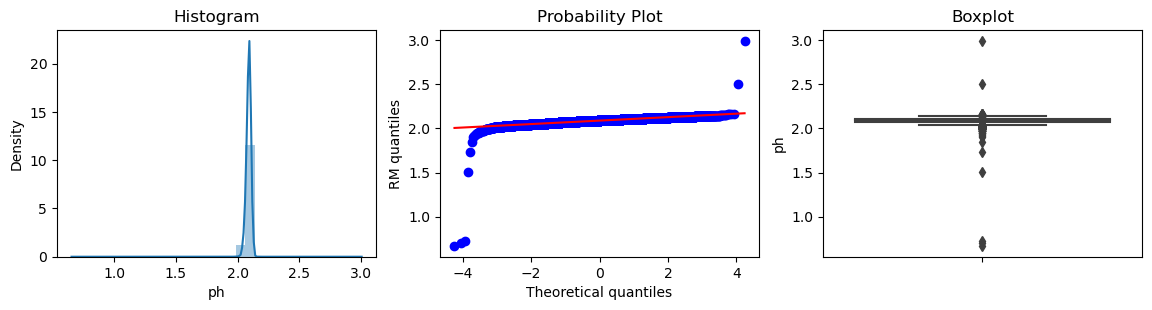

conversion: sqrt


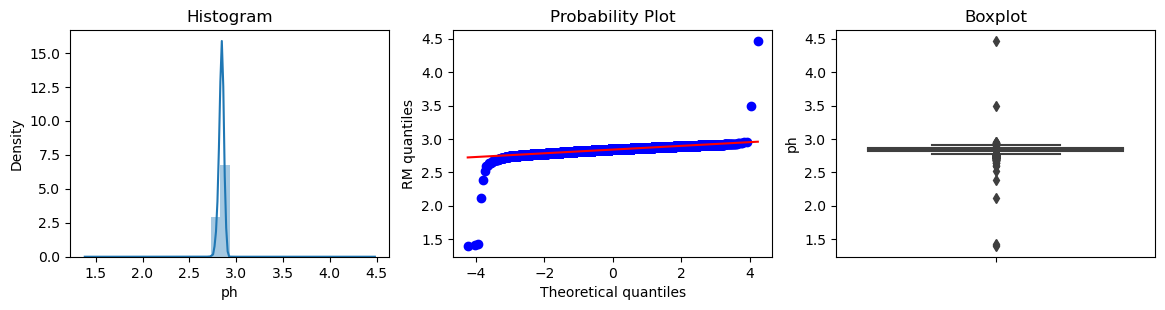

In [43]:
for conversion_type in (set(conversion_options.keys())):
    diagnostic_plots(df, 'ph', conversion_type)

In [44]:
print('''cube root and square root conversions put the mean of the data in the middle.
The spread can benefit from adjusting its boundaries''')

cube root and square root conversions put the mean of the data in the middle.
The spread can benefit from adjusting its boundaries


In [45]:
# find lower and upper boundaries of 'ph'
ph_lower_limit, ph_upper_limit = find_normal_boundaries(df, 'ph', 3)

# Apply boundaries to outliers
df['ph'] = np.where(df['ph'] > ph_upper_limit, ph_upper_limit,
                     np.where(df['ph'] < ph_lower_limit, ph_lower_limit,
                      df['ph']))

conversion: cbrt


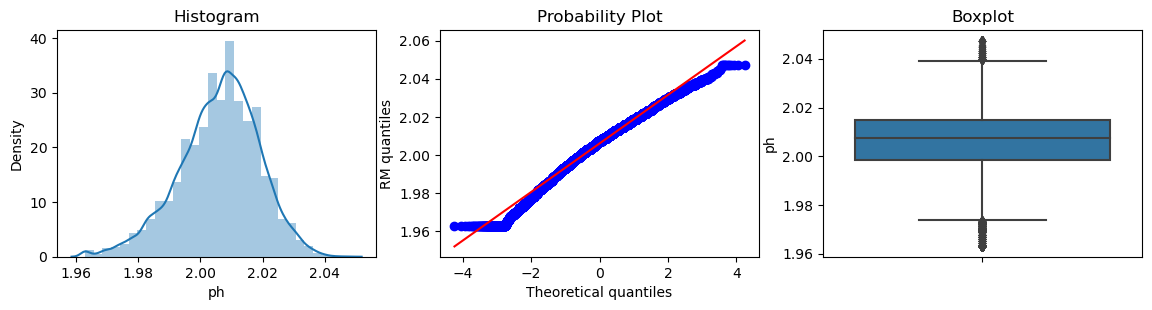

conversion: abs


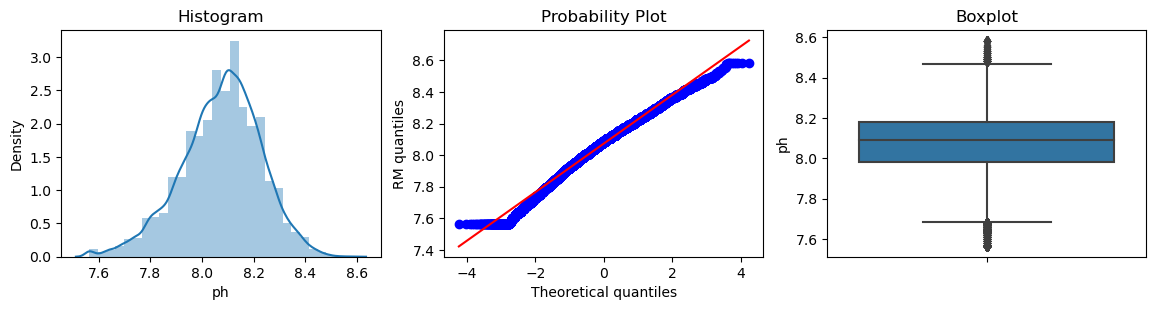

conversion: log


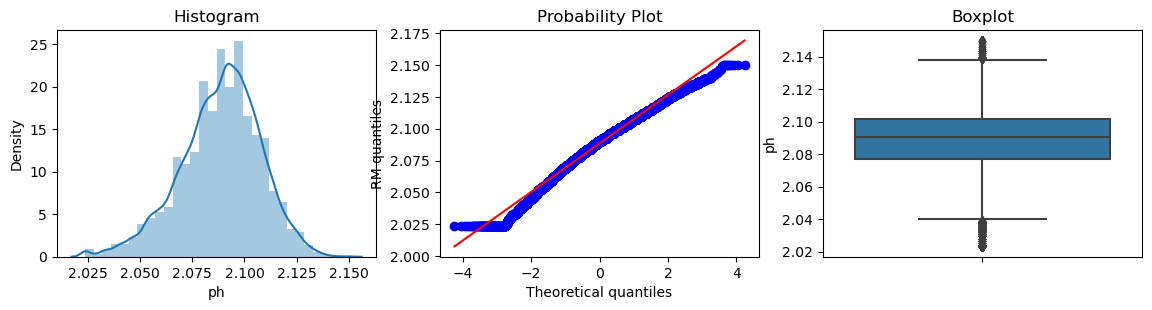

conversion: sqrt


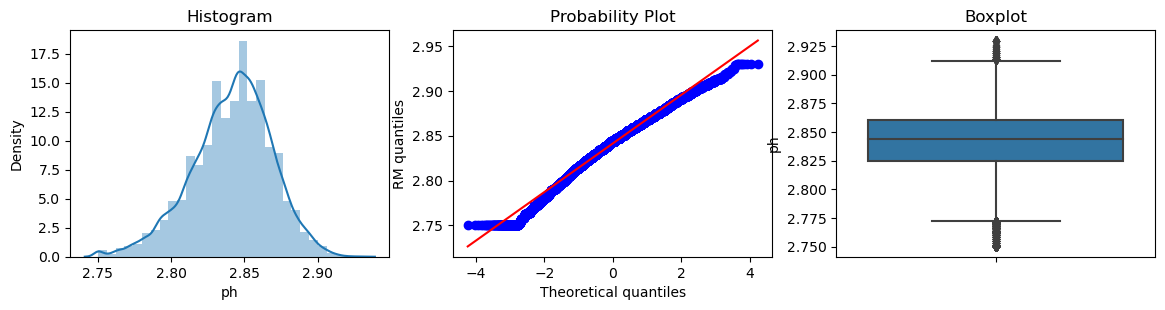

In [46]:
for conversion_type in (set(conversion_options.keys())):
    diagnostic_plots(df, 'ph', conversion_type)

In [47]:
print('''The boundaries modification benefitted the square root conversion best. 
It not only helped its horizontal range, but also compressed the frequency range.''')

The boundaries modification benefitted the square root conversion best. 
It not only helped its horizontal range, but also compressed the frequency range.


In [48]:
# conversion of ph to its square root
df.ph = np.sqrt(df.ph)

#### Scatter plots

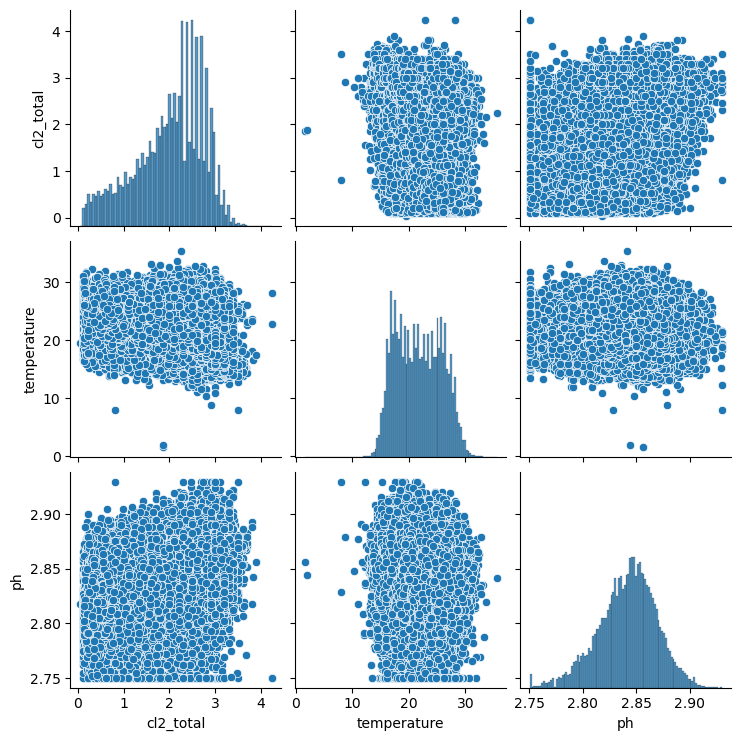

In [57]:
sns.pairplot(df.select_dtypes(include=['float64']))#, hue='yearMonth_t_coli_pct')
plt.show()

#### Correlation Matrix

<AxesSubplot:>

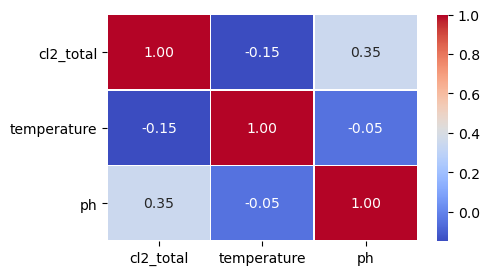

In [65]:
# Correlation Matrix
pearsoncorr = df.select_dtypes(include=['float64']).corr(method='pearson')

plt.figure(figsize= (5, 3))

sns.heatmap(pearsoncorr,
            xticklabels=pearsoncorr.columns,
            yticklabels=pearsoncorr.columns,
            cmap='coolwarm',
            fmt=".2f",
            annot=True,
            linewidth=0.25)

In [64]:
print('''
The float64 columns do not seem to have a relationship with one another, in the scatter plots; however,
the Correlation Matrix show a relationship between ph and cl2_total, at a value of 0.35. ''')


The float64 columns do not seem to have a relationship with one another, in the scatter plots; however,
the Correlation Matrix show a relationship between ph and cl2_total, at a value of 0.35. 


#### Time Series Analysis

In [149]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [66]:
# add a feature for year from 'date_sampled' value
df['year'] = pd.DatetimeIndex(df.date_sampled).year

# add a feature for month from 'date_sampled' value
df['month'] = pd.DatetimeIndex(df.date_sampled).month

# add a feature to contain month and year
df['month_year'] = df.date_sampled.dt.to_period('M')

In [67]:
df.sample(3)

,FR_NUM,date_sampled,source,sample_id,cl2_total,temperature,ph,ph_Basic,t_coliform_A,year,month,month_year
5973,259356,2015-04-22,257 SYS,W1042479,2.12,21.8,2.854820,1,1,2015,4,2015-04
12217,275121,2016-03-28,204A SYS,W1098672,2.50,18.8,2.884441,1,1,2016,3,2016-03
49029,370798,2021-09-27,174 SYS,W1453756,1.46,24.0,2.817801,1,1,2021,9,2021-09


#### cl2_total Time Series

In [170]:
# load data
cl2_ts_df = df[['date_sampled', 'cl2_total']]

# set index to date
cl2_ts_df.set_index('date_sampled', inplace=True)

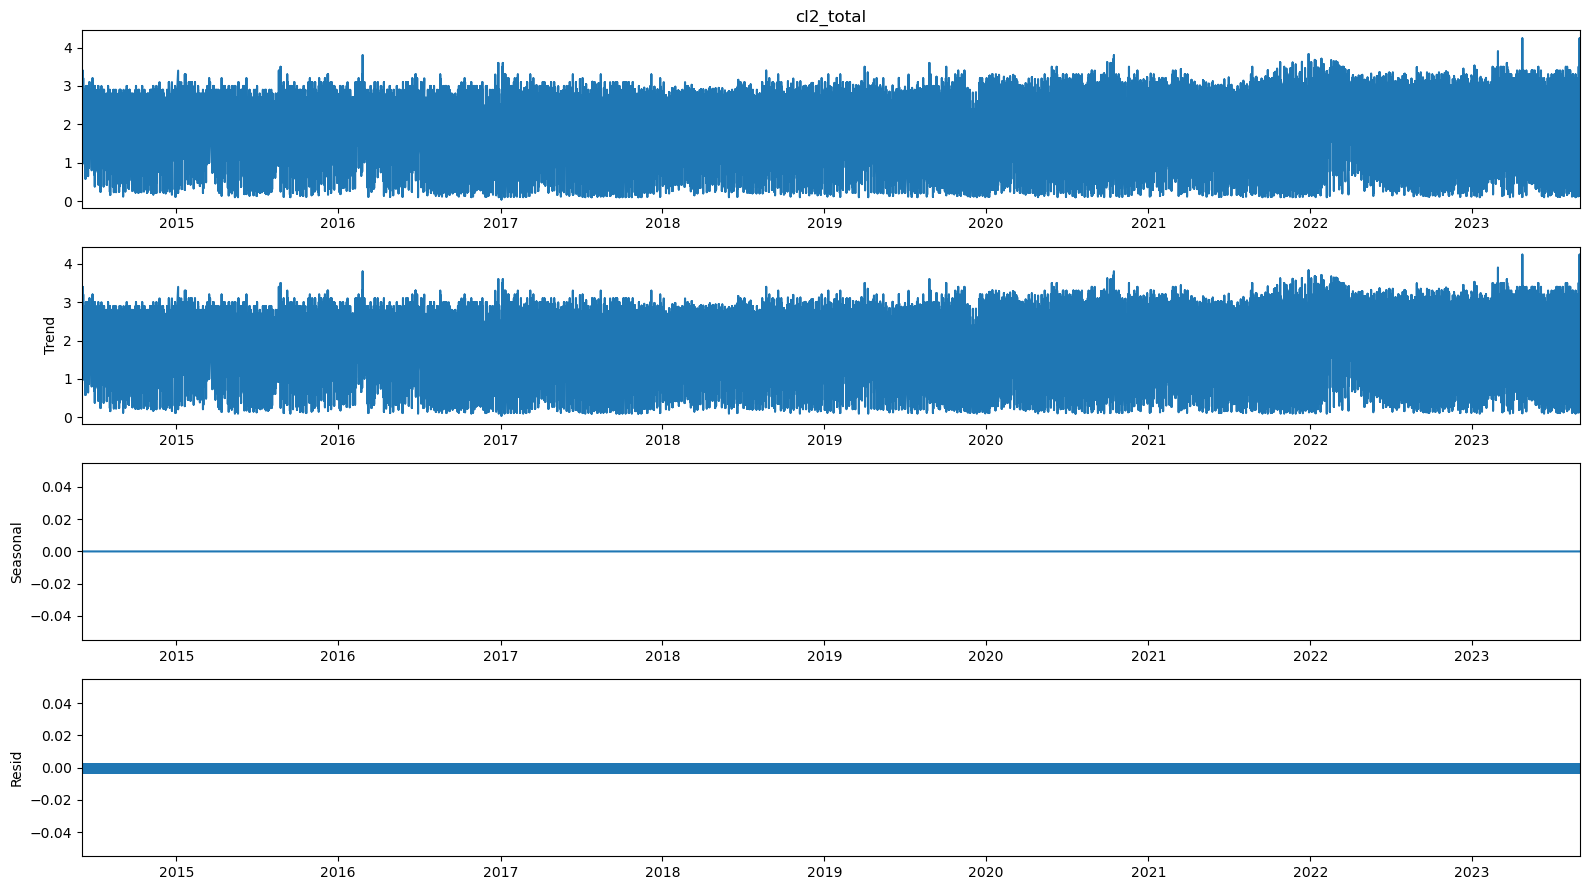

In [206]:
cl2_seasonal_decompose = seasonal_decompose(x=cl2_ts_df['cl2_total'], period=1)

fig = cl2_seasonal_decompose.plot()
fig.set_size_inches((16, 9))
# Tight layout to realign things
fig.tight_layout()
plt.show();

#### temperature Time Series

In [188]:
# load data
temp_ts_df = df[['date_sampled', 'temperature']]

# set index to date
temp_ts_df.set_index('date_sampled', inplace=True)

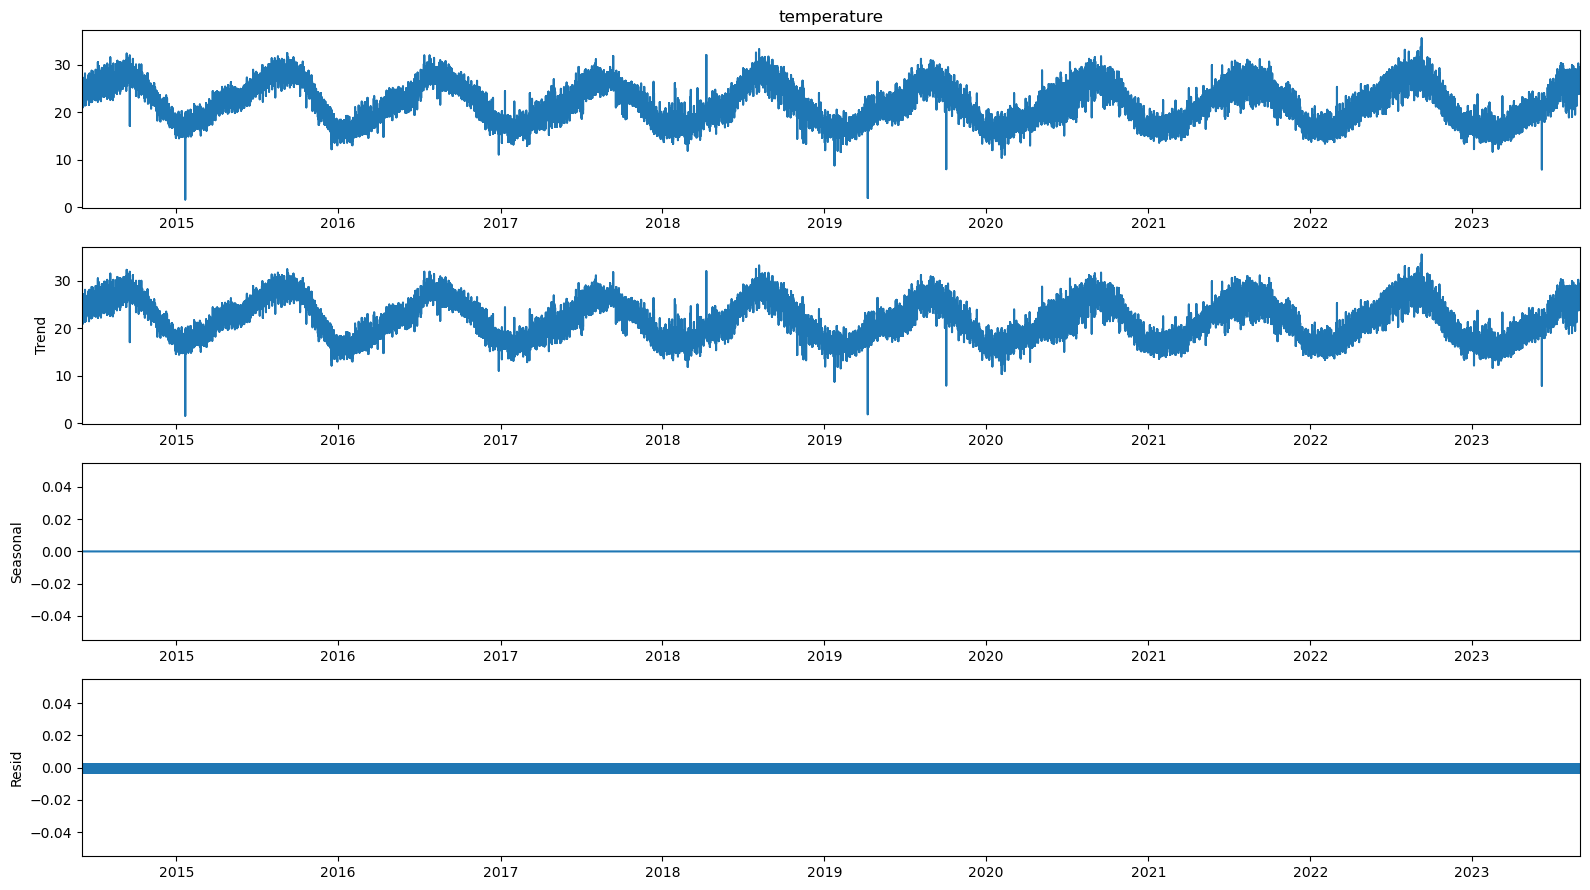

In [209]:
temp_seasonal_decompose = seasonal_decompose(x=temp_ts_df['temperature'], period=1)

fig = temp_seasonal_decompose.plot()
fig.set_size_inches((16, 9))
# Tight layout to realign things
fig.tight_layout()
plt.show();

#### ph Time Series

In [210]:
# load data
ph_ts_df = df[['date_sampled', 'ph']]

# set index to date
ph_ts_df.set_index('date_sampled', inplace=True)

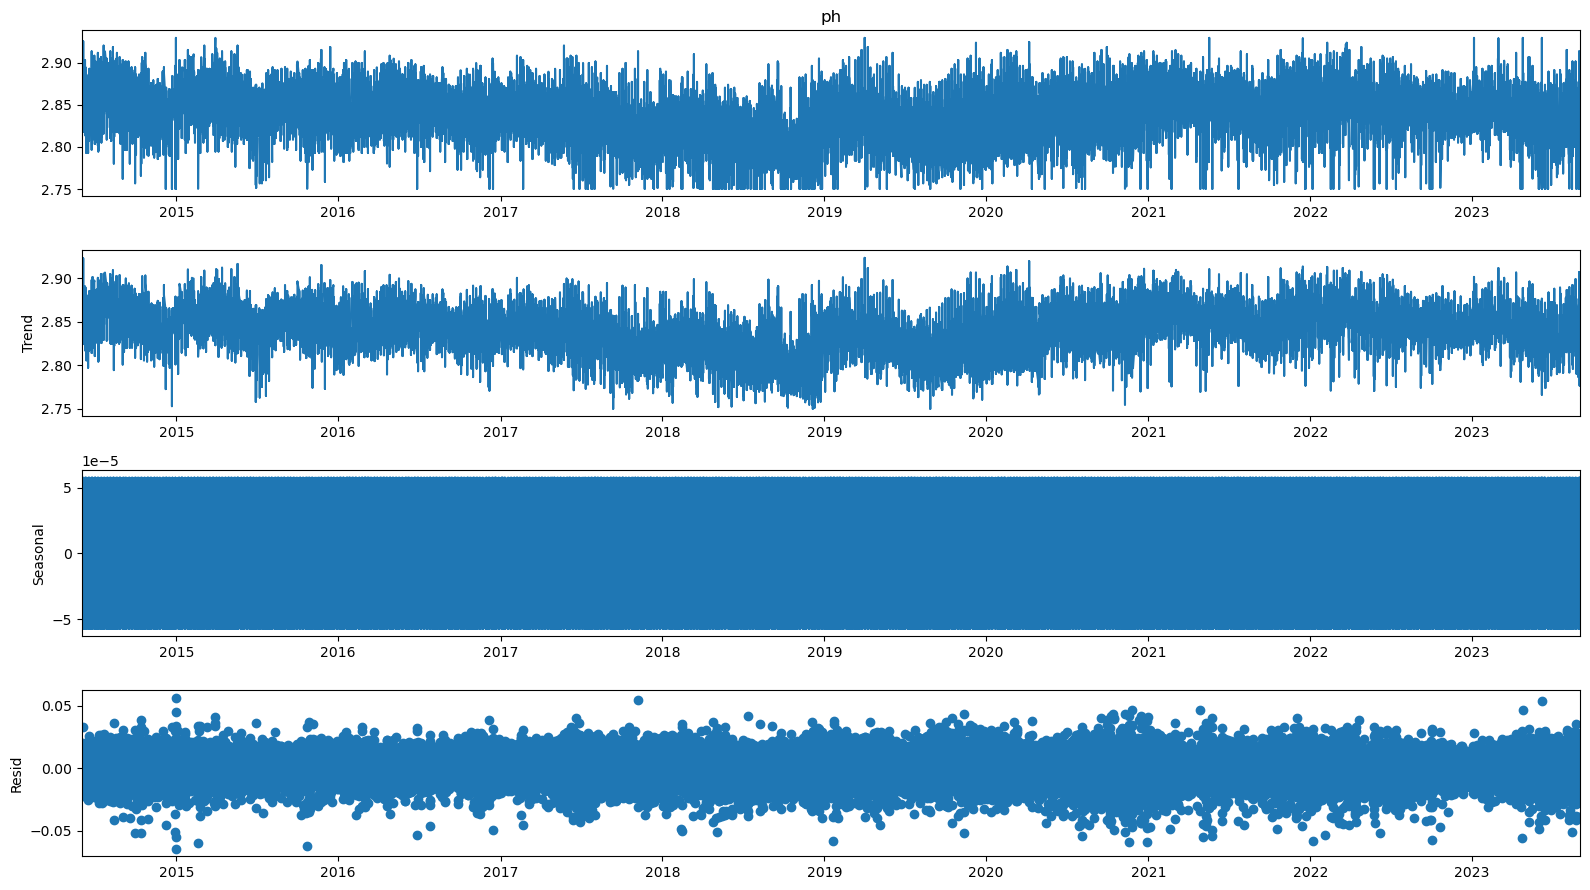

In [213]:
ph_seasonal_decompose = seasonal_decompose(x=ph_ts_df['ph'], period=2)

fig = ph_seasonal_decompose.plot()
fig.set_size_inches((16, 9))
# Tight layout to realign things
fig.tight_layout()
plt.show();

#### Test and Train Data Split

In [46]:
from sklearn.model_selection import train_test_split

#### Business purpose (from website)

* A positive result for coliform from one single test is not enough to constitute an MCL (Maximum Contaminant Level) violation. An acute violation occurs when a site that initially tested positive is repeat tested and either the initial sample or one of the repeat samples is positive for E. coli. A monthly MCL violation occurs if more than 5 percent of all routine and repeat tests are coliform positive. A positive coliform result from a single routine test may be due to sampling error or bacteria in the testing mechanism but not in the drinking water pipes.

In [ ]:
print('''There are no acute violations in the dataset, as all e_coli values equal 'A' 
across all {} rows, which is 'absent' e_coli.'''.format(pd.DataFrame(df.e_coli.value_counts()).iloc[0].values[0]))

df.e_coli.value_counts()

There are no acute violations in the dataset, as all e_coli values equal 'A' 
across all 61509 rows, which is 'absent' e_coli.


A    61509
Name: e_coli, dtype: int64

In [ ]:
print('''A monthly MCL violation occurs if more than 5 percent of all routine and repeat tests are coliform positive. 
We have 'P', present, values in the t_coliform feature.''',"\n")

df.t_coliform.value_counts()

A monthly MCL violation occurs if more than 5 percent of all routine and repeat tests are coliform positive. 
We have 'P', present, values in the t_coliform feature. 



A    61402
P      107
Name: t_coliform, dtype: int64

#### Feature Engineering


In [ ]:
# Adding a month-year value to best identify MCL violations
df['year'] = pd.DatetimeIndex(df.date_sampled).year
df['month'] = pd.DatetimeIndex(df.date_sampled).month
df['yearMonth'] =  df.year.astype(str) + '-' + df.month.astype(str)

In [ ]:
# Identify yearMonth where t_coliform was Present, 'P'
ym_df = pd.DataFrame(df.query("t_coliform == 'P'").yearMonth.unique())
ym_df.columns = ['yearMonth']

# Get all data from df for yearMonth where there was t_coliform present
ym_df = df.merge(ym_df, left_on='yearMonth', right_on='yearMonth', how='inner')

In [ ]:
# Crosstab results, into dataframe
ym_df = pd.DataFrame(pd.crosstab(ym_df.yearMonth, ym_df.t_coliform)).reset_index()

# Add a Total column
ym_df['Total'] = ym_df.A + ym_df.P

# Add a t_coli percent column, representing the percentage of cases in the month, when t_coli was Present
ym_df['yearMonth_t_coli_pct'] = round(ym_df.P / ym_df.Total * 100)

In [ ]:
# Add yearMonth_t_coli_pct to main dataframe
df = df.merge(ym_df[['yearMonth', 'yearMonth_t_coli_pct']], left_on='yearMonth', right_on='yearMonth', how='left')

# Update Nan values to 0.0
df['yearMonth_t_coli_pct'] = df.yearMonth_t_coli_pct.fillna(0.0)


# Convert floats to integer
df['yearMonth_t_coli_pct'] = df.yearMonth_t_coli_pct.astype(int)

In [ ]:
print('''There are no t_coliform instances per Month, of more than 5% in the dataset.
When present, it has equaled as high as 1% for the respective month only.''',"\n")
df.yearMonth_t_coli_pct.value_counts()

There are no t_coliform instances per Month, of more than 5% in the dataset.
When present, it has equaled as high as 1% for the respective month only. 



0    53121
1     8388
Name: yearMonth_t_coli_pct, dtype: int64

### EDA


##### Subset

In [ ]:
df_subset = df[['date_sampled', 't_coliform', 'cl2_total', 'e_coli', 'temperature', 'ph', 'yearMonth_t_coli_pct']]

df_subset

,date_sampled,t_coliform,cl2_total,e_coli,temperature,ph,yearMonth_t_coli_pct
0,2014-06-02,A,2.80,A,22.8,8.03,0
1,2014-06-02,A,2.22,A,23.6,8.00,0
2,2014-06-02,A,1.95,A,25.5,7.99,0
3,2014-06-02,A,1.78,A,24.5,7.95,0
4,2014-06-02,A,2.70,A,22.2,8.02,0
...,...,...,...,...,...,...,...
61504,2023-08-07,A,0.51,A,22.8,8.06,0
61505,2023-08-07,A,2.60,A,24.2,8.12,0
61506,2023-08-07,A,1.72,A,22.4,8.04,0
61507,2023-08-07,A,0.55,A,24.2,8.00,0


##### Get dummies

In [ ]:
df_dummies = pd.get_dummies(df_subset.select_dtypes(include='object'))

# join uses index as default on join
df_subset = df_subset.join(df_dummies, how='outer')

# drop 'object' columns
df_subset.drop(columns=df_subset.select_dtypes(include='object').columns.tolist(), inplace=True)

df_subset

,date_sampled,cl2_total,temperature,ph,yearMonth_t_coli_pct,t_coliform_A,t_coliform_P,e_coli_A
0,2014-06-02,2.80,22.8,8.03,0,1,0,1
1,2014-06-02,2.22,23.6,8.00,0,1,0,1
2,2014-06-02,1.95,25.5,7.99,0,1,0,1
3,2014-06-02,1.78,24.5,7.95,0,1,0,1
4,2014-06-02,2.70,22.2,8.02,0,1,0,1
...,...,...,...,...,...,...,...,...
61504,2023-08-07,0.51,22.8,8.06,0,1,0,1
61505,2023-08-07,2.60,24.2,8.12,0,1,0,1
61506,2023-08-07,1.72,22.4,8.04,0,1,0,1
61507,2023-08-07,0.55,24.2,8.00,0,1,0,1


#### get dummies for year

In [ ]:
### get dummies for year

##### Target variable imbalance

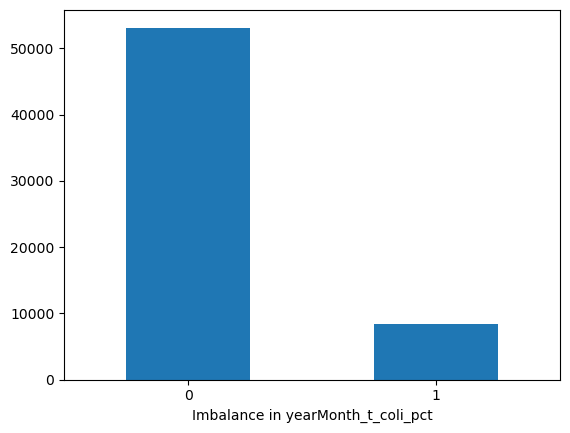

In [ ]:
df_subset.yearMonth_t_coli_pct.value_counts().plot(kind='bar', rot=0)
plt.xlabel('Imbalance in yearMonth_t_coli_pct')
plt.show()

#### Balance target

In [ ]:
df_subset.yearMonth_t_coli_pct

0        0
1        0
2        0
3        0
4        0
        ..
61504    0
61505    0
61506    0
61507    0
61508    0
Name: yearMonth_t_coli_pct, Length: 61509, dtype: int32

##### Pairplot of numerical variables

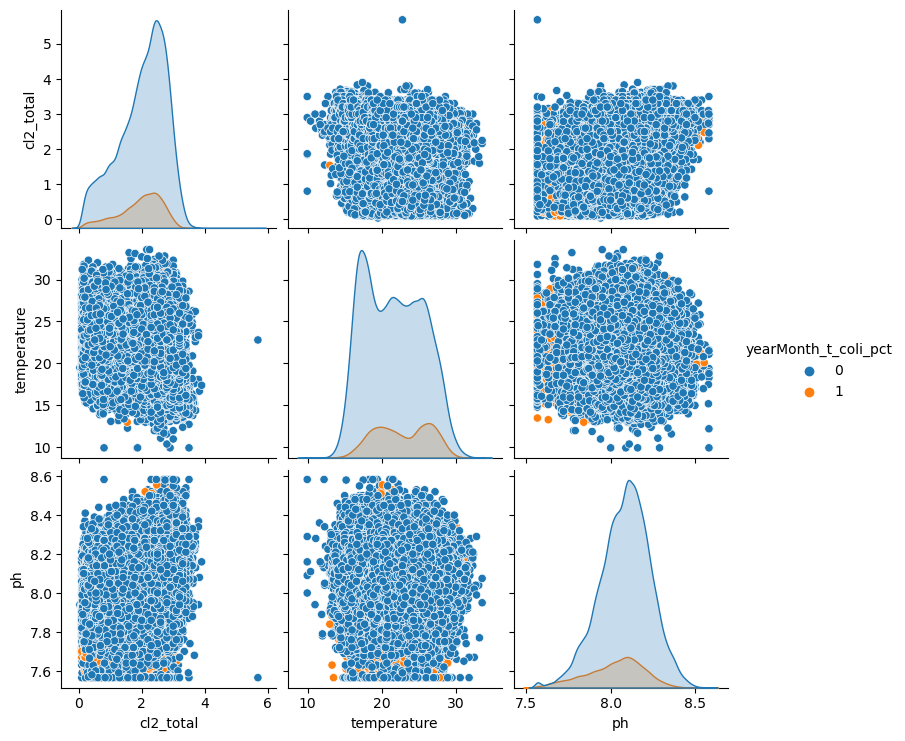

In [ ]:
sns.pairplot(df_subset.select_dtypes(include=['float64', 'int64', 'int32']), hue='yearMonth_t_coli_pct')
plt.show()

### Create a Target classifier, representing a source that had t_coliform present at any point in the dataset.
### source_t_coliform_historically

In [ ]:
# Identify 'source' which has had t_coliform in the past
source_df = pd.DataFrame(df.query("t_coliform == 'P'").source.unique())
source_df.columns = ['source']
source_df['source_t_coliform_historically'] = 1

In [ ]:
# Merge source_df into main dataframe
df = df.merge(source_df, left_on='source', right_on='source', how='left')

# Convert missing values to 0
df['source_t_coliform_historically'] = df.source_t_coliform_historically.fillna(0)

# Convert to int
df['source_t_coliform_historically'] = df.source_t_coliform_historically.astype(int)

In [ ]:
# initiate sklearn LabelEncoder
le = preprocessing.LabelEncoder()

# LabelEncoder 'source' feature
le.fit(df['source'])
df['source_le'] =  le.transform(df['source'])

# LabelEncoder 'yearMonth' feature
le.fit(df['yearMonth'])
df['yearMonth_le'] =  le.transform(df['yearMonth'])

In [ ]:
# Binary values for t_coliform
df['t_coliform_bin'] = np.where(df.t_coliform == 'A', 0, 1)

## Proposed target variable

<AxesSubplot:>

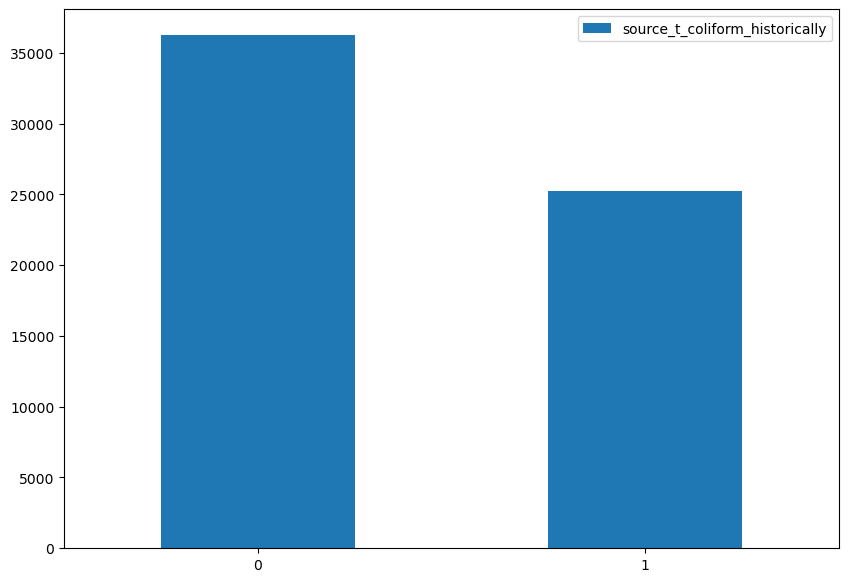

In [ ]:
# More than half of the "sources" have had t_coliform present at some point
pd.DataFrame(df.source_t_coliform_historically.value_counts()).plot.bar(rot=0, stacked=True, figsize=(10,7))

This graph shows ticks for the year when a label encoded source, had t_coliform present,
between the years 2015 through 2018. This is in effort to try and recognize patterns of recurring 
t_coliform at specific sources during this stretch of time. 



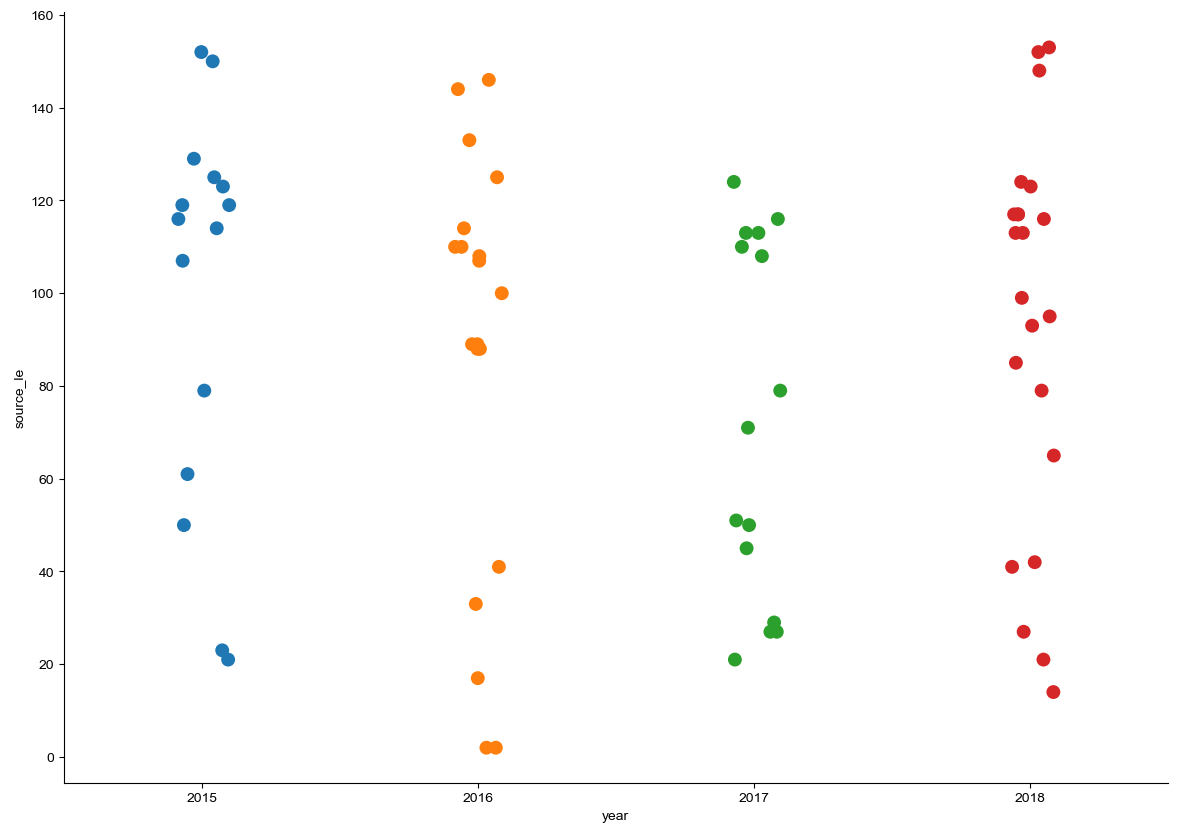

In [ ]:
print('''This graph shows ticks for the year when a label encoded source, had t_coliform present,
between the years 2015 through 2018. This is in effort to try and recognize patterns of recurring 
t_coliform at specific sources during this stretch of time.''',"\n")

sns.catplot(data=df.query("t_coliform_bin == 1 and year <= 2018 and year >= 2015"), x='year', y='source_le', s=10, height=8.27, aspect=11.7/8.27)
sns.set_style("ticks",{'axes.grid' : True})

<AxesSubplot:>

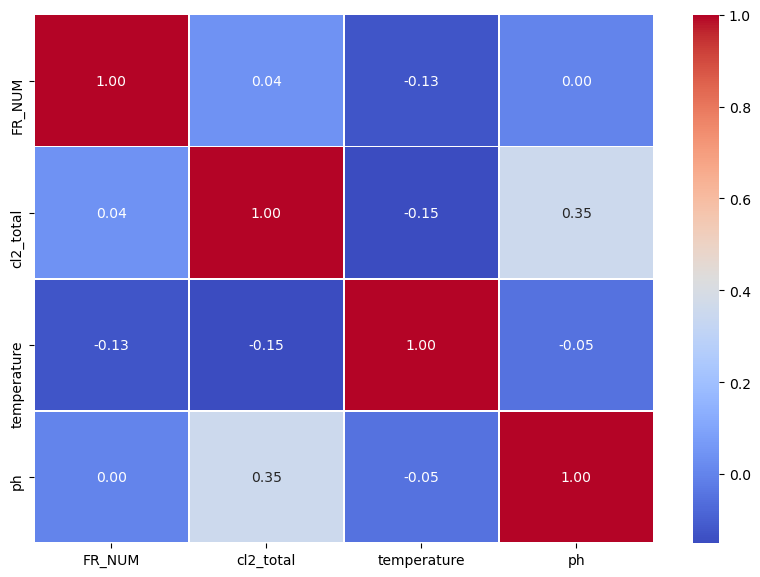

In [ ]:
# Correlation Matrix
pearsoncorr = df.corr(method='pearson')

plt.figure(figsize= (10, 7))

sns.heatmap(pearsoncorr,
            xticklabels=pearsoncorr.columns,
            yticklabels=pearsoncorr.columns,
            cmap='coolwarm',
            fmt=".2f",
            annot=True,
            linewidth=0.25)